In [1]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import SGD, Adam

In [2]:
model = VGG16(include_top=False, input_shape=(150, 150, 3))
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(6, activation = 'softmax')(x)
# define the new model
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

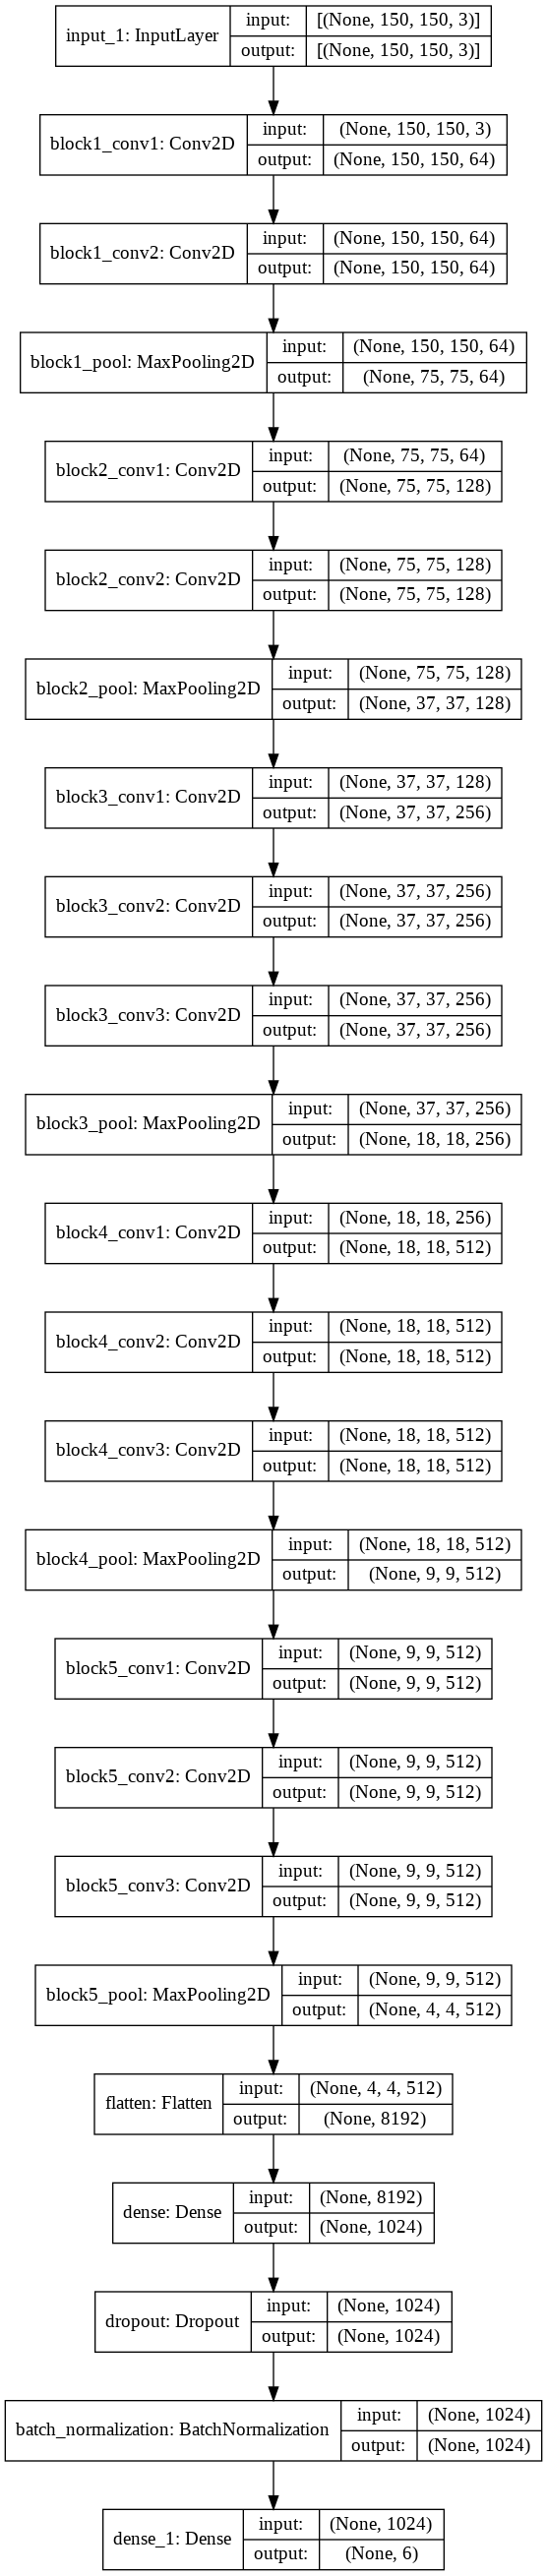

In [3]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [4]:
# necessary imports
import os
import cv2
import numpy as np
import pandas as pd
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
train_dir = './drive/MyDrive/seg_train/seg_train/'
test_dir = './drive/MyDrive/seg_test/seg_test/'
pred_dir = './drive/MyDrive/seg_pred/seg_pred/'

In [7]:
#used for Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True,validation_split=0.3)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
training_set = train_datagen.flow_from_directory(train_dir,
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            classes = ["buildings","forest","glacier","mountain","sea","street"],
                                            class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_dir,
                                        target_size = (150, 150),
                                        batch_size = 32,
                                        classes = ["buildings","forest","glacier","mountain","sea","street"],
                                        class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [9]:
opt = SGD(lr=1e-4,momentum=0.99)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])

In [10]:
#Used to Avoid Overfitting
checkpoint = ModelCheckpoint("vgg16_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='max')

In [11]:
#Training the model
hist = model.fit_generator(steps_per_epoch=100,generator=training_set, validation_data= test_set, validation_steps=10,epochs=100,callbacks=[checkpoint,early])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 28s 252ms/step - loss: 1.6253 - accuracy: 0.3840 - val_loss: 0.6930 - val_accuracy: 0.7469

Epoch 00001: val_accuracy improved from -inf to 0.74687, saving model to vgg16_weights.h5
Epoch 2/100
100/100 [==============================] - 26s 257ms/step - loss: 0.6995 - accuracy: 0.7431 - val_loss: 0.5125 - val_accuracy: 0.8219

Epoch 00002: val_accuracy improved from 0.74687 to 0.82187, saving model to vgg16_weights.h5
Epoch 3/100
100/100 [==============================] - 25s 251ms/step - loss: 0.6222 - accuracy: 0.7719 - val_loss: 0.4330 - val_accuracy: 0.8438

Epoch 00003: val_accuracy improved from 0.82187 to 0.84375, saving model to vgg16_weights.h5
Epoch 4/100
100/100 [==============================] - 25s 249ms/step - loss: 0.5489 - accuracy: 0.8095 - val_loss: 0.5300 - val_accuracy: 0.8219

Epoch 00004: val_accuracy did not improve from 0.84375
Epoch 5/100
100/100 [==============================] - 25s 249ms/step - loss: 0.5

In [12]:
#Saving and Loading Weights
model.save_weights("vgg16_weights.h5")
model.load_weights("vgg16_weights.h5")

#Evaluating the model
score = model.evaluate_generator(test_set,1000)
print("Validation Loss: ",score[0])
print("Validation Accuracy: ",score[1])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Validation Loss:  0.37821313738822937
Validation Accuracy:  0.8663333058357239


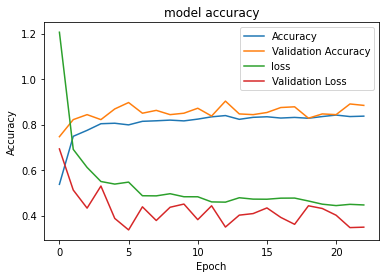

In [13]:
'''LEARNING CURVE'''

import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [14]:
pred_set = test_datagen.flow_from_directory(
        pred_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

Found 7301 images belonging to 6 classes.


In [15]:
pred_set.reset()

In [16]:
pred=model.predict_generator(pred_set, steps=len(pred_set), verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


229/229 [==============================] - 20s 87ms/step


In [17]:
predicted_classes = list(np.argmax(pred, axis=1))
classes_dict = {0:"buildings",1:"forest",2:"glacier",3:"mountain",4:"sea",5:"street"}
predicted_classes_string=[]
for i,j in enumerate(predicted_classes):
  for v,c in classes_dict.items():
    if v==j:
      predicted_classes_string.append(c)
      break
filenames = pred_set.filenames

y_hat=[]
num_pord=1
for i,name in enumerate(filenames):
  num_prod=1
  y_hat.append(name.split("/")[0])
  for v,c in classes_dict.items():
    if c==y_hat[i]:
      y_hat[i]=v
      break

In [18]:
results=pd.DataFrame({"file":filenames, "class":predicted_classes_string})

In [19]:
pd.set_option('display.max_rows', 20)
print(results)

                     file      class
0     buildings/10004.jpg     street
1     buildings/10048.jpg  buildings
2     buildings/10052.jpg  buildings
3     buildings/10073.jpg     street
4     buildings/10082.jpg     street
...                   ...        ...
7296      street/9963.jpg     street
7297      street/9972.jpg     street
7298      street/9987.jpg     street
7299      street/9988.jpg     street
7300      street/9996.jpg     street

[7301 rows x 2 columns]


In [20]:
#Evaluating the Model Predictions
score = model.evaluate_generator(pred_set,1000)
print("\n")
print("Test Loss: ",score[0])
print("Test Accuracy: ",score[1])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '




Test Loss:  0.2605915367603302
Test Accuracy:  0.9300096035003662


In [21]:
classes = ["buildings","forest","glacier","mountain","sea","street"]
#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix=confusion_matrix(y_hat, predicted_classes)
print("Confusion Matrix\n")
print(confusion_matrix)

Confusion Matrix

[[1057    6    0    1    7   73]
 [   1 1158    0    0    4    3]
 [   2    6 1259   30   31    2]
 [   1    6  147 1065   74    4]
 [   9    6   25    9 1076    3]
 [  37   12    1    1   10 1175]]


In [22]:
#Classification Report
print("Classification Report\n")
print(classification_report(y_hat, predicted_classes, target_names=classes))

Classification Report

              precision    recall  f1-score   support

   buildings       0.95      0.92      0.94      1144
      forest       0.97      0.99      0.98      1166
     glacier       0.88      0.95      0.91      1330
    mountain       0.96      0.82      0.89      1297
         sea       0.90      0.95      0.92      1128
      street       0.93      0.95      0.94      1236

    accuracy                           0.93      7301
   macro avg       0.93      0.93      0.93      7301
weighted avg       0.93      0.93      0.93      7301

